In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install contextily

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,338 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123598 files and dire

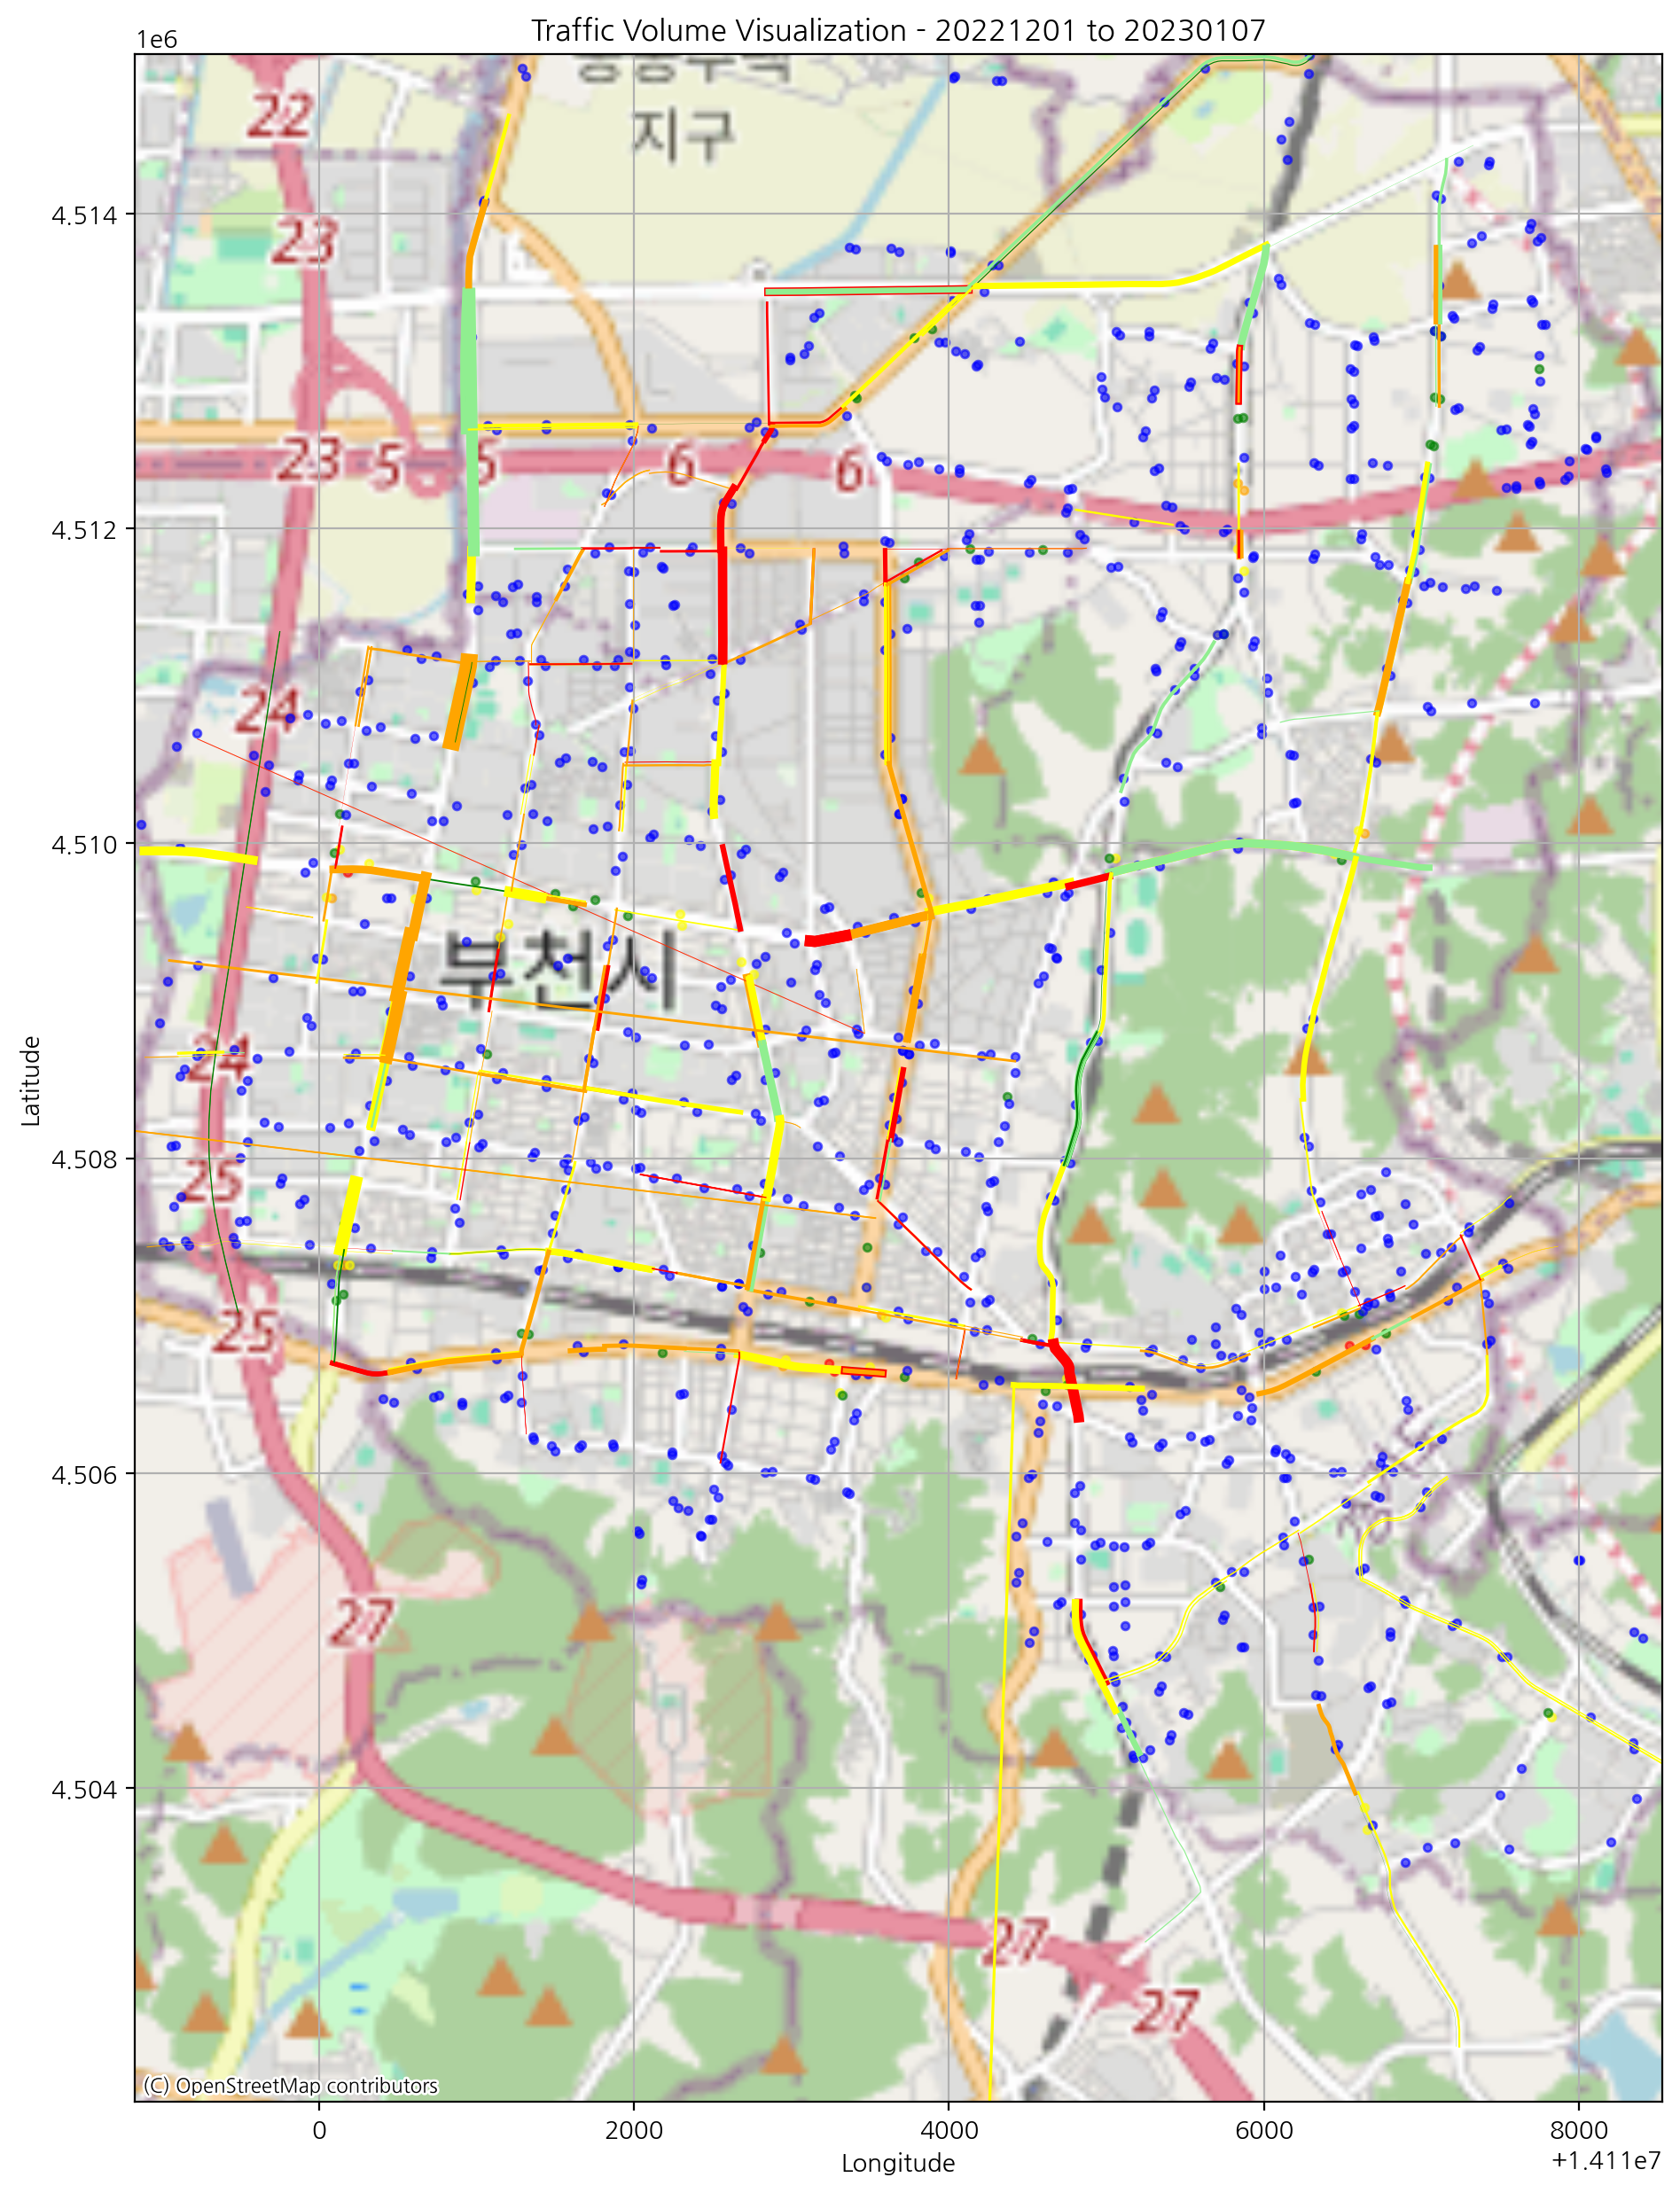

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import contextily as ctx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import folium
# 폰트 설정 (필요한 경우)
plt.rcParams["font.family"] = 'NanumGothic'

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/my_project/traffic.csv')
df['coords'] = df['coords'].apply(lambda x: eval(x))

# Bus stop data (예시로 추가한 부분, 실제 데이터 경로로 교체 필요)
df_bus=pd.read_csv('/content/drive/MyDrive/my_project/버스정류소현황.csv',encoding=  'cp949')
df_bus=df_bus[df_bus['시군명']=='부천시']
df_bus_stop=pd.read_csv('/content/drive/MyDrive/my_project/버스_승차+하차+환승_2024_08_09.csv')
# 버스정류소 승객수 특정 날짜 필터링 ('20230701' 예시)
specific_date = 20230701
filtered_df_bus_stop = df_bus_stop[df_bus_stop['run_ymd'] == specific_date]

# GeoDataFrame 생성
geometry = [LineString(segment) for segment in df['coords']]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# 좌표 참조 시스템 설정 및 변환
gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=3857)

# df_bus를 GeoDataFrame으로 변환
bus_geometry = [Point(xy) for xy in zip(df_bus['WGS84경도'], df_bus['WGS84위도'])]
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=bus_geometry)

# 좌표계를 gdf와 동일하게 EPSG:3857로 변환
gdf_bus.set_crs(epsg=4326, inplace=True)
gdf_bus = gdf_bus.to_crs(epsg=3857)
start_date = 20221201
end_date = 20230107
start_time = 1
end_time = 24

filtered_gdf = gdf[(gdf['analysisdate'] >= start_date) &
                   (gdf['analysisdate'] <= end_date) &
                   (gdf['analysistime'] >= start_time) &
                   (gdf['analysistime'] <= end_time)]

# 필터링된 데이터가 존재하는지 확인
if filtered_gdf.empty:
    print(f"No data available for the date: {specific_date}")
else:
    # 지도 범위 설정 (지도 크기 제한)
    xlim = (filtered_gdf.total_bounds[0], filtered_gdf.total_bounds[2])
    ylim = (filtered_gdf.total_bounds[1], filtered_gdf.total_bounds[3])

    # 시각화
    fig, ax = plt.subplots(figsize=(15, 15), dpi=200)  # dpi를 낮춰서 해상도를 줄임

    # 속도에 따른 색상 결정 함수
    def get_color(speed):
        if speed < 15:
            return 'red'
        elif 15 <= speed < 20:
            return 'orange'
        elif 20 <= speed < 30:
            return 'yellow'
        elif 30 <= speed < 40:
            return 'lightgreen'
        else:
            return 'green'

    # 속도에 따른 색상 추가
    for idx, row in filtered_gdf.iterrows():
        color = get_color(row['speed'])
        ax.plot(*row.geometry.xy, color=color, linewidth=row['volume'] / 500)

    # 지도 범위 설정
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Basemap 추가 (OpenStreetMap)
    #ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)  # zoom을 낮춰서 이미지 크기 줄임

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)  # zoom을 낮춰서 이미지 크기 줄임

    for idx, row in filtered_df_bus_stop.iterrows():
        bus_stop = row['bus_stop_ars_no']
        passenger_count = row['total_passenger_count']

        # 정류소 위치 찾기
        bus_location = gdf_bus[gdf_bus['정류소번호'] == bus_stop]
        if not bus_location.empty:
            x, y = bus_location.geometry.x.iloc[0], bus_location.geometry.y.iloc[0]

            # 승객 수에 따른 색상 결정 (5단계로 나눔)
            if passenger_count < 1000:
                color = 'blue'
            elif 1000 <= passenger_count < 2000:
                color = 'green'
            elif 2000 <= passenger_count < 4000:
                color = 'yellow'
            elif 4000 <= passenger_count < 6000:
                color = 'orange'
            else:
                color = 'red'

            # 정류소 위치에 따라 색상이 다른 포인트 추가
            ax.scatter(x, y, color=color, s=10, marker='o', alpha=0.6)

            # 승객 수 라벨 추가
            #plt.text(x, y, str(passenger_count), fontsize=7, ha='center', color='black')

 # 그래프 타이틀 및 라벨 설정
    plt.title(f'Traffic Volume Visualization - {start_date} to {end_date}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # 시각화 결과 보여주기
    plt.show()


In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
from folium.plugins import BeautifyIcon

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/my_project/traffic.csv')
df['coords'] = df['coords'].apply(lambda x: eval(x))

# Bus stop data
df_bus = pd.read_csv('/content/drive/MyDrive/my_project/버스정류소현황.csv', encoding='cp949')
df_bus = df_bus[df_bus['시군명'] == '부천시']
df_bus_stop = pd.read_csv('/content/drive/MyDrive/my_project/버스_승차+하차+환승_2024_08_09.csv')

# 버스정류소 승객수 특정 날짜 필터링 ('20230701' 예시)
specific_date = 20230701
filtered_df_bus_stop = df_bus_stop[df_bus_stop['run_ymd'] == specific_date]
# 돌발사고
df_accidents = pd.read_csv('/content/drive/MyDrive/my_project/돌발건수.csv')

# GeoDataFrame 생성
geometry = [LineString(segment) for segment in df['coords']]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# 좌표계를 WGS84로 설정 (Folium은 WGS84 좌표계를 사용)
gdf.set_crs(epsg=4326, inplace=True)

# df_bus를 GeoDataFrame으로 변환
bus_geometry = [Point(xy) for xy in zip(df_bus['WGS84경도'], df_bus['WGS84위도'])]
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=bus_geometry)
gdf_bus.set_crs(epsg=4326, inplace=True)

# 사고 데이터를 GeoDataFrame으로 변환
accident_geometry = [Point(lon, lat) for lon, lat in zip(df_accidents['uneocc_pstn_lot'], df_accidents['uneocc_pstn_lat'])]
gdf_accidents = gpd.GeoDataFrame(df_accidents, geometry=accident_geometry)
specific_type=['사고 - 차량 대 차량','사고 - 차량 대 사람']
gdf_accidents = gdf_accidents[gdf_accidents['uneocc_type_nm'].isin(specific_type)]

# 데이터 필터링
start_date = 20221201
end_date = 20230107
start_time = 1
end_time = 24

filtered_gdf = gdf[(gdf['analysisdate'] >= start_date) &
                   (gdf['analysisdate'] <= end_date) &
                   (gdf['analysistime'] >= start_time) &
                   (gdf['analysistime'] <= end_time)]

# Folium 지도 생성
if filtered_gdf.empty:
    print(f"No data available for the given date and time range.")
else:
    # 지도 중심 설정 (LineString의 중심점 사용)
    center = filtered_gdf.geometry.centroid.unary_union.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=12)

    # 속도에 따른 색상 결정 함수
    def get_color(speed):
        if speed < 15:
            return 'red'
        elif 15 <= speed < 20:
            return 'orange'
        elif 20 <= speed < 30:
            return 'yellow'
        elif 30 <= speed < 40:
            return 'lightgreen'
        else:
            return 'green'

    # LineString 데이터를 Folium 지도에 추가
    for idx, row in gdf.iterrows():
      color = get_color(row['speed'])
      weight = row['volume'] / 200  # 볼륨 값에 따라 선 두께 조정

    # 팝업 내용 설정
      popup_content = f"노선명: {row['roadname']}<br>볼륨: {row['volume']}<br>속도: {row['speed']}km/h"

      folium.PolyLine(
        locations=[(y, x) for x, y in row['geometry'].coords],
        color=color,
        weight=weight,
        opacity=1,
        popup=folium.Popup(popup_content, max_width=300)
      ).add_to(m)

    # 정류소별 승객 수에 따라 색상 및 마커 추가
    for idx, row in filtered_df_bus_stop.iterrows():
        bus_stop = row['bus_stop_ars_no']
        passenger_count = row['total_passenger_count']

        # 정류소 위치 찾기
        bus_location = gdf_bus[gdf_bus['정류소번호'] == bus_stop]
        if not bus_location.empty:
            x, y = bus_location.geometry.x.iloc[0], bus_location.geometry.y.iloc[0]

            # 승객 수에 따른 색상 결정 (5단계로 나눔)
            if passenger_count < 500:
                color = 'blue'
            elif 500 <= passenger_count < 1000:
                color = 'green'
            elif 1000 <= passenger_count < 2500:
                color = 'yellow'
            elif 2500 <= passenger_count < 4000:
                color = 'orange'
            else:
                color = 'red'

            # Folium CircleMarker로 정류소 추가
            folium.CircleMarker(
                location=[y, x],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"정류소: {bus_stop}<br>승객수: {passenger_count}"
            ).add_to(m)
   # 사고 데이터 시각화 (Point)
    for idx, row in gdf_accidents.iterrows():
    # 사고 유형에 따른 아이콘 설정
        if row['uneocc_type_nm'] == '사고 - 차량 대 차량':
          icon_shape = 'car'  # '차대 차'의 경우 차 모양 아이콘
        elif row['uneocc_type_nm'] == '사고 - 차량 대 사람':
          icon_shape = 'user'  # '차대 사람'의 경우 사람 모양 아이콘
        else:
          icon_shape = 'info-sign'  # 기본 아이콘 (기타 유형)
        folium.Marker(
          location=[row.geometry.y, row.geometry.x],
          popup=folium.Popup(
            f"도로명: {row['road_nm']}<br>"
            f"시작 위치: {row['bgng_node_nm']}<br>"
            f"종료 위치: {row['end_node_nm']}<br>"
            f"사고 유형: {row['uneocc_type_nm']}<br>"
            f"건수: {row['uneocc_nocs']}",
            max_width=300
          ),
          icon=BeautifyIcon(icon=icon_shape, icon_shape='marker', background_color='red' if row['uneocc_nocs'] >= 10 else 'orange')
        ).add_to(m)


    # 지도를 HTML 파일로 저장
    m.save('/content/drive/MyDrive/my_project/filtered_map_with_stops.html')

    print("지도 저장 완료: /content/drive/MyDrive/my_project/filtered_map_with_stops.html")

<ipython-input-4-aa3bc10eed5f>:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = filtered_gdf.geometry.centroid.unary_union.centroid


지도 저장 완료: /content/drive/MyDrive/my_project/filtered_map_with_stops.html


In [ ]:
print(df[(gdf['analysisdate'] == 20221213) & (gdf['analysistime'] == 17)].head(10))
grouped_counts = gdf.groupby(['analysisdate', 'analysistime']).size().reset_index(name='count')
print(grouped_counts)

   analysisdate  analysistime      linkid roadname  maxspeed    stnodeid  \
4      20221213            17  2105072001      길주로       0.0  2420052400   
5      20221213            17  2115017200     송내대로       0.0  2420007500   
6      20221213            17  2125005102      오정로      70.0  2420036400   
7      20221213            17  2425094700      옥산로       0.0  2420029700   

  stnodename  stnodelat   stnodelng    ednodeid  ...   ednodelng  \
4     까치울사거리  37.506182  126.811375  2420041400  ...  126.797425   
5    송내역앞교차로  37.488501  126.753828  1660000500  ...  126.753021   
6    봉오대로사거리  37.532070  126.789507  2420034500  ...  126.786623   
7     상오정삼거리  37.520194  126.780514  2420029400  ...  126.780312   

                                              coords  volume  speed  \
4  [[126.81135, 37.50628], [126.81004, 37.50651],...  1682.0  29.84   
5  [[126.75353, 37.48853], [126.75325, 37.48721],...   218.0  28.10   
6  [[126.78928, 37.53204], [126.7884, 37.53138], ...   802.0  20.

In [12]:
import pandas as pd
import folium
from folium import Popup
from branca.colormap import linear
import geopandas as gpd
from shapely.geometry import LineString
from ipywidgets import interact, widgets

# 데이터 로드
data = df  # df를 기존 데이터 프레임으로 사용

# LineString을 사용하여 geometry 생성
geometry = [LineString(segment) for segment in data['coords']]

# GeoDataFrame 생성
gdf = gpd.GeoDataFrame(data, geometry=geometry)

# 좌표계를 WGS84로 설정 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Volume과 Speed에 따른 색상과 폭 설정
gdf['volume_bins'] = pd.qcut(gdf['volume'], 5, labels=False)
gdf['speed_bins'] = pd.qcut(gdf['speed'], 5, labels=False)

# Color map 정의
speed_color_map = linear.RdYlBu_11.scale(gdf['speed'].min(), gdf['speed'].max())
gdf['volume_weight'] = gdf['volume_bins'] + 1  # 1부터 5까지의 가중치 설정

# 지도 생성 함수 정의
def create_map(filtered_gdf):
    if filtered_gdf.empty:
        print("No data available for the selected date and time.")
        return folium.Map(location=[37.50572, 126.75418], zoom_start=12)

    # 지도 생성
    m = folium.Map(location=[37.50572, 126.75418], zoom_start=14)  # 확대 수준을 높여서 도로가 잘 보이도록 설정

    # 도로를 지도에 추가
    for _, row in filtered_gdf.iterrows():
        # Folium은 (latitude, longitude) 순서로 좌표를 받음
        locations = [(lat, lon) for lon, lat in row['geometry'].coords]
        folium.PolyLine(
            locations=locations,
            color=speed_color_map(row['speed']),
            weight=2 * row['volume_weight'],  # 도로의 폭을 설정
            opacity=0.7,
            popup=Popup(f"도로명: {row['roadname']}<br>Volume: {row['volume']}<br>Speed: {row['speed']}", max_width=300)
        ).add_to(m)

    # 속도 색상 범례 추가
    speed_color_map.add_to(m)

    return m

# 날짜 및 시간 선택 위젯 생성 및 지도 업데이트 함수
def update_map(date, time):
    # 날짜와 시간 필터링
    filtered_gdf = gdf[(gdf['analysisdate'] == int(date)) & (gdf['analysistime'] == int(time))]

    # 필터링된 데이터가 있는지 확인
    if filtered_gdf.empty:
        print("No data available for the selected date and time.")

    m = create_map(filtered_gdf)

    return m

# 위젯 설정
date_picker = widgets.Text(value='20221213', description='Date:', disabled=False)
time_picker = widgets.IntSlider(value=16, min=0, max=23, step=1, description='Time:')

# 인터랙티브 지도 생성
interact(update_map, date=date_picker, time=time_picker)

interactive(children=(Text(value='20221213', description='Date:'), IntSlider(value=16, description='Time:', ma…

<function __main__.update_map(date, time)>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import contextily as ctx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import folium
# 폰트 설정 (필요한 경우)
plt.rcParams["font.family"] = 'NanumGothic'

# 데이터 불러오기
ac = pd.read_csv('/content/drive/MyDrive/my_project/돌발건수.csv')
ac.head()
# df_bus를 GeoDataFrame으로 변환
ac_geometry = [Point(xy) for xy in zip(ac['uneocc_pstn_lat'], ac['uneocc_pstn_lot'])]
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=bus_geometry)

ocrn_ymd  ocrn_hour     link_id road_nm  bgng_node_id bgng_node_nm  \
0  2024-01-01          0  2420083400     신흥로    2420026200        대림산업앞   
1  2024-01-01         17  2420018800     소향로    2420005200  리틀소시에부천상동본원   
2  2024-01-01          0  2420021700     상동로    2420006600      상동영프러스앞   
3  2024-01-01         18  2420155300     삼작로    2420055200          신월로   
4  2024-01-01          0  2420160300     성지로    2420052200        성주파크빌   

   end_node_id end_node_nm uneocc_type_cd uneocc_type_nm  uneocc_pstn_lat  \
0   2420025800      먹거리삼거리            avv   사고 - 차량 대 차량        37.500287   
1   2420006000       중앙사거리            avv   사고 - 차량 대 차량        37.503481   
2   2420006800      상동역사거리            avv   사고 - 차량 대 차량        37.505196   
3   2420047100       성곡사거리            avv   사고 - 차량 대 차량        37.519861   
4   2420052100      나들이사거리            avv   사고 - 차량 대 차량        37.523783   

   uneocc_pstn_lot  uneocc_nocs  
0       126.776962            4  
1       126.751951            5  
2       126.753022           16  
3       126.805561            2  
4       126.811253            8